In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.utils.data.dataset import TensorDataset
from torch.utils.data import DataLoader, Dataset
from sklearn.preprocessing import QuantileTransformer as qt
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import Generator
from Discriminator import Discriminator
from ParticleDataset import ParticleDataset

In [2]:
QT = qt(output_distribution='normal',n_quantiles=10000,subsample=100000)
dataset = ParticleDataset('Full_Sim_10M.csv', 'Full_Sim_55M_stats.csv',QT)
df_N = pd.read_csv('Full_Sim_10M.csv')
df_N[' rx'] = np.sqrt(df_N[' xx']**2+df_N[' yy']**2)
df_N['theta'] = np.arccos(df_N[' pzz']/np.sqrt(df_N[' pxx']**2+df_N[' pyy']**2+df_N[' pzz']**2))
dataloader = DataLoader(dataset.data, batch_size = 2**9, shuffle = True)

In [4]:
N_z=100
mps_device = torch.device('mps')
net_G = Generator.Generator(N_z).to(mps_device)
net_G.load_state_dict(torch.load('saved_Gen.pt'))
net_D = Discriminator().to(mps_device)
#print(net_G,net_D)

In [5]:
optimizer_G = optim.Adam(net_G.parameters(), lr = 0.0001, betas= (0.5,0.999))
optimizer_D = optim.Adam(net_D.parameters(), lr = 0.0001, betas= (0.5,0.999))

In [6]:
def weights_init(m):
    if isinstance(m,nn.Linear):
        nn.init.normal_(m.weight.data, 0.0 ,0.02)
    elif isinstance(m,nn.BatchNorm1d):
        nn.init.normal_(m.weight.data, 1,0.02)

In [7]:
def plot_correlations(x,y,bins=[400,400],loglog=False,Xlim=None,Ylim=None):
  H,xb,yb = np.histogram2d(x,y,bins=bins,range=[[x.min(), x.max()], [y.min(), y.max()]])
  X , Y = np.meshgrid(xb,yb)
  plt.pcolormesh(X,Y,np.log10(H.T))
  if loglog:
    plt.xscale('log')
    plt.yscale('log')
  if Xlim!=None:
      plt.xlim(Xlim)
  if Ylim!=None:
      plt.ylim(Ylim)
  plt.colorbar()
  plt.show()

In [8]:
def plots(df):
  plot_correlations(df[' xx'],df[' yy'])
  Ebin = 10**np.linspace(np.log10(df[' eneg'].min()), np.log10(df[' eneg'].max()),400)
  Tbin = 10**np.linspace(np.log10(df[' time'].min()), np.log10(df[' time'].max()),400)
  plot_correlations(df[' time'],df[' eneg'] ,bins = [Tbin,Ebin], loglog=True)
  plot_correlations(df[' rx'],df['theta'])
  plot_correlations(df[' phi_p'],df[' phi_x'])

In [9]:
def transform(df, dataset, fake_p):
    norm_param_list = [' rx',' phi_x',' rp',' phi_p',' pzz',' eneg',' time']
    A_p = dataset.quantiles.inverse_transform(fake_p)
    for i in range(len(norm_param_list)):
        max = dataset.norm['max'][norm_param_list[i]]
        min = dataset.norm['min'][norm_param_list[i]]
        if i in [2,5,6]:
            df[norm_param_list[i]] = min + (max-min)*np.exp(A_p[:,i])
        elif i==4:
            df[norm_param_list[i]] = max - (max-min)*np.exp(A_p[:,i])
        elif i in [0,1,3]:
            df[norm_param_list[i]] = min + (max-min)*A_p[:,i]
    df[' xx'] = df[' rx']*np.cos(df[' phi_x']-np.pi)
    df[' yy'] = df[' rx']*np.sin(df[' phi_x']-np.pi)
    df[' pxx'] = df[' rp']*np.cos(df[' phi_p']-np.pi)
    df[' pyy'] = df[' rp']*np.sin(df[' phi_p']-np.pi)
    df['theta'] = np.arccos(df[' pzz']/np.sqrt(df[' pzz']**2+df[' rp']**2))
    return df

Starting Training Loop...


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:12: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):


 epochs:   0%|          | 0/100 [00:00<?, ?it/s]

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "
/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


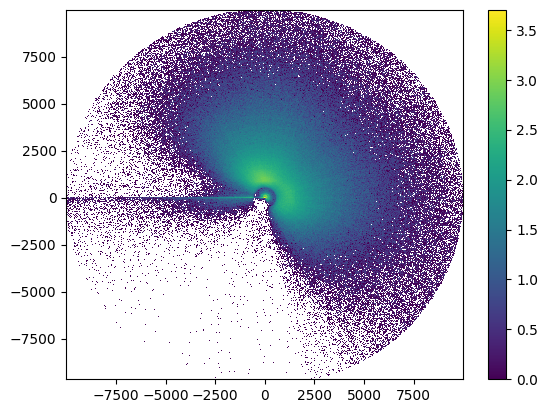

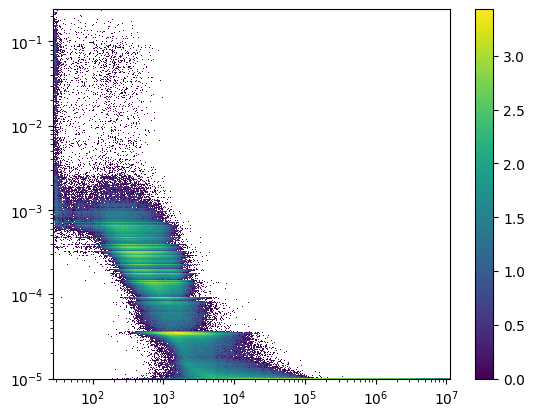

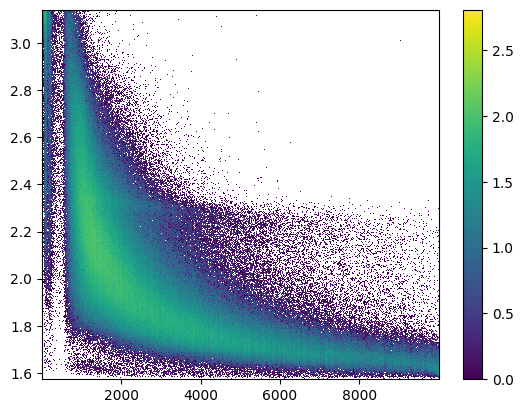

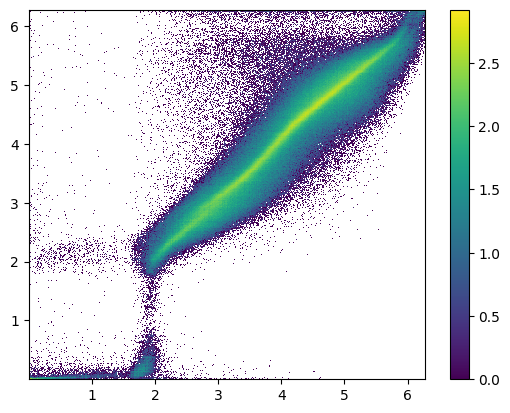

0/100	Loss_D: -559.0823	Loss_G: 17537.2473


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


1/100	Loss_D: -701.1369	Loss_G: 18297.6063


 batch: 0it [00:00, ?it/s]

2/100	Loss_D: -927.6703	Loss_G: 19145.7735


 batch: 0it [00:00, ?it/s]

3/100	Loss_D: -822.4959	Loss_G: 19392.5191


 batch: 0it [00:00, ?it/s]

4/100	Loss_D: -1036.7873	Loss_G: 20973.6233


 batch: 0it [00:00, ?it/s]

5/100	Loss_D: -1100.9628	Loss_G: 22337.6799


 batch: 0it [00:00, ?it/s]

6/100	Loss_D: -1362.6550	Loss_G: 22711.3207


 batch: 0it [00:00, ?it/s]

7/100	Loss_D: -1538.0743	Loss_G: 23962.5665


 batch: 0it [00:00, ?it/s]

8/100	Loss_D: -1484.9965	Loss_G: 25588.6918


 batch: 0it [00:00, ?it/s]

9/100	Loss_D: -1550.0555	Loss_G: 27070.9133


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


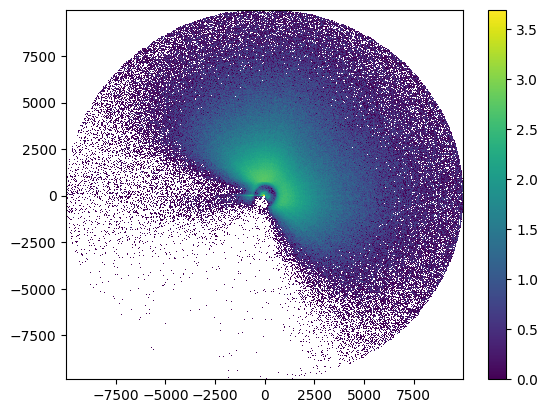

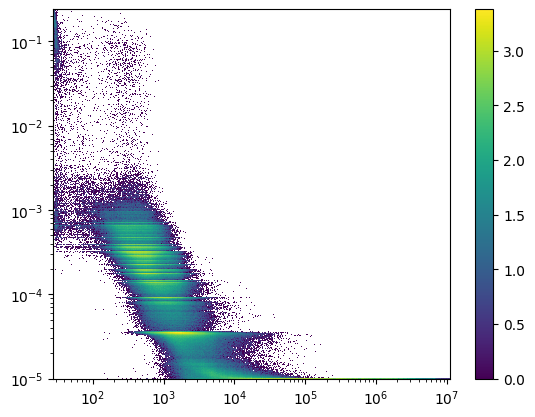

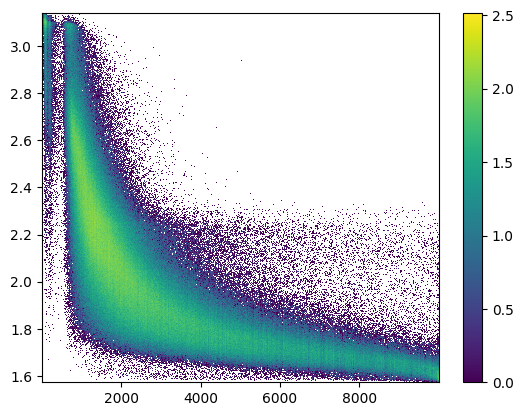

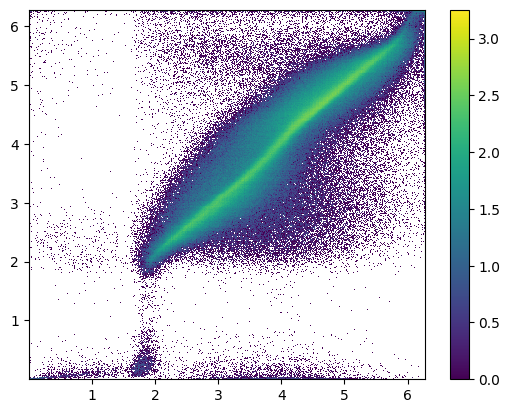

10/100	Loss_D: -1754.3839	Loss_G: 28377.6654


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


11/100	Loss_D: -1926.5484	Loss_G: 29791.8740


 batch: 0it [00:00, ?it/s]

12/100	Loss_D: -2034.8180	Loss_G: 30249.6001


 batch: 0it [00:00, ?it/s]

13/100	Loss_D: -2245.2645	Loss_G: 30648.3208


 batch: 0it [00:00, ?it/s]

14/100	Loss_D: -2404.6165	Loss_G: 31583.1075


 batch: 0it [00:00, ?it/s]

15/100	Loss_D: -2509.0381	Loss_G: 34159.1791


 batch: 0it [00:00, ?it/s]

16/100	Loss_D: -2490.1592	Loss_G: 34805.0220


 batch: 0it [00:00, ?it/s]

17/100	Loss_D: -2553.8480	Loss_G: 35674.9794


 batch: 0it [00:00, ?it/s]

18/100	Loss_D: -2765.5521	Loss_G: 36310.6934


 batch: 0it [00:00, ?it/s]

19/100	Loss_D: -3039.0252	Loss_G: 37639.5023


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


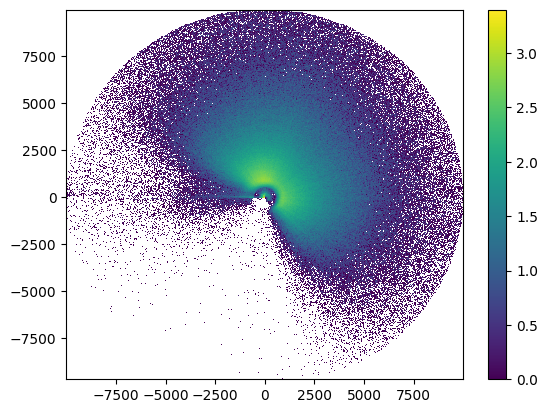

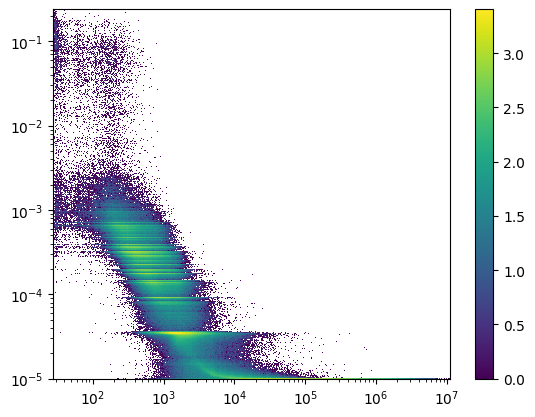

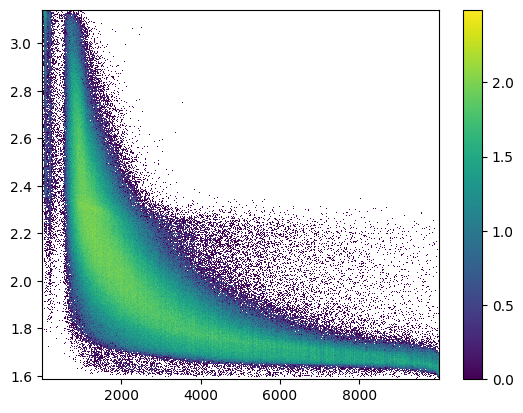

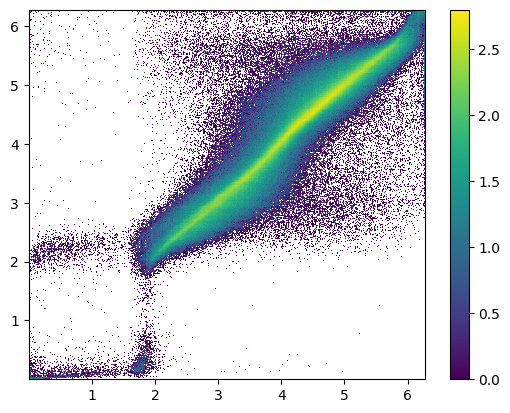

20/100	Loss_D: -3268.0983	Loss_G: 38447.1963


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


21/100	Loss_D: -3685.1747	Loss_G: 38813.6087


 batch: 0it [00:00, ?it/s]

22/100	Loss_D: -4039.5484	Loss_G: 38641.7463


 batch: 0it [00:00, ?it/s]

23/100	Loss_D: -4688.4749	Loss_G: 38200.1620


 batch: 0it [00:00, ?it/s]

24/100	Loss_D: -5151.5202	Loss_G: 37753.7606


 batch: 0it [00:00, ?it/s]

25/100	Loss_D: -5923.7078	Loss_G: 39901.2809


 batch: 0it [00:00, ?it/s]

26/100	Loss_D: -6990.3210	Loss_G: 41486.8950


 batch: 0it [00:00, ?it/s]

27/100	Loss_D: -8405.8955	Loss_G: 41089.3967


 batch: 0it [00:00, ?it/s]

28/100	Loss_D: -10734.0497	Loss_G: 39532.1491


 batch: 0it [00:00, ?it/s]

29/100	Loss_D: -12491.0043	Loss_G: 41037.0245


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


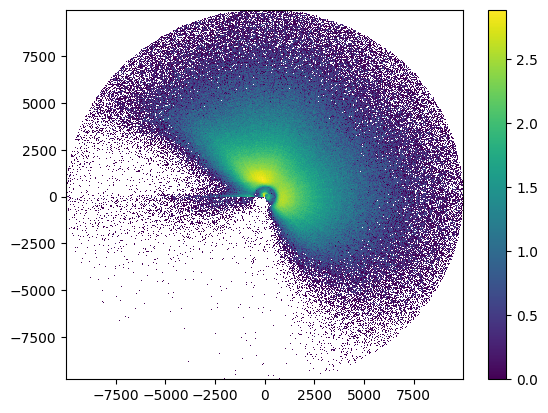

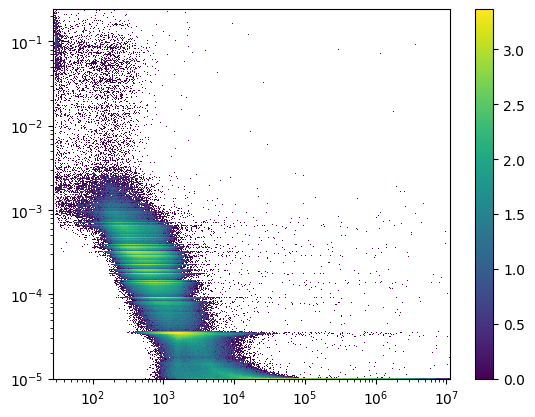

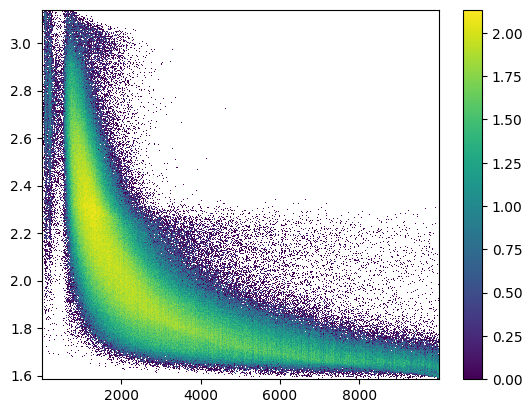

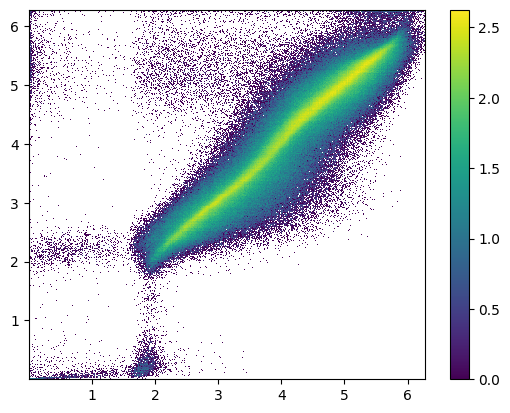

30/100	Loss_D: -14442.5129	Loss_G: 41793.2342


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


31/100	Loss_D: -15974.0247	Loss_G: 46333.3717


 batch: 0it [00:00, ?it/s]

32/100	Loss_D: -17400.8174	Loss_G: 48248.0911


 batch: 0it [00:00, ?it/s]

33/100	Loss_D: -18270.9847	Loss_G: 51855.5818


 batch: 0it [00:00, ?it/s]

34/100	Loss_D: -19274.0877	Loss_G: 54126.8475


 batch: 0it [00:00, ?it/s]

35/100	Loss_D: -20489.1484	Loss_G: 55980.8912


 batch: 0it [00:00, ?it/s]

36/100	Loss_D: -22031.4143	Loss_G: 56232.3300


 batch: 0it [00:00, ?it/s]

37/100	Loss_D: -23651.1162	Loss_G: 55993.5246


 batch: 0it [00:00, ?it/s]

38/100	Loss_D: -25124.4275	Loss_G: 55905.3186


 batch: 0it [00:00, ?it/s]

39/100	Loss_D: -26167.7262	Loss_G: 55465.9919


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


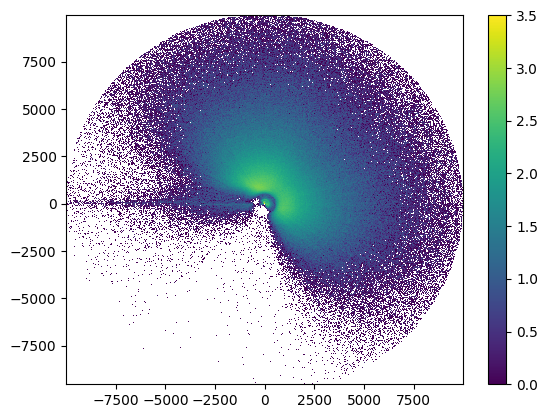

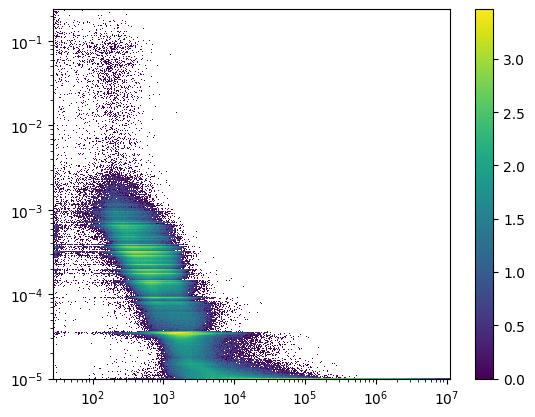

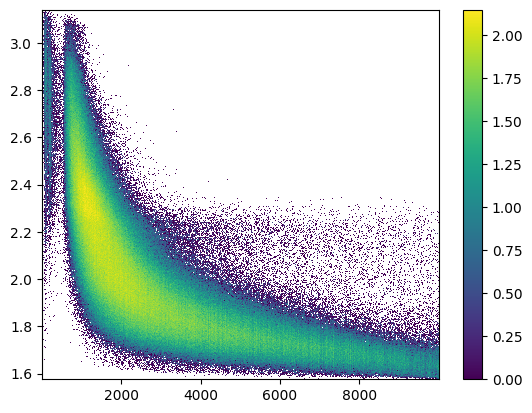

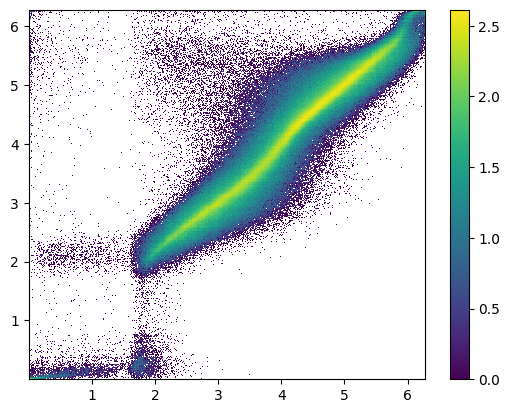

40/100	Loss_D: -26602.3291	Loss_G: 55261.0058


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


41/100	Loss_D: -27783.1711	Loss_G: 56778.1228


 batch: 0it [00:00, ?it/s]

42/100	Loss_D: -29027.1074	Loss_G: 61396.6625


 batch: 0it [00:00, ?it/s]

43/100	Loss_D: -30667.1651	Loss_G: 63678.7686


 batch: 0it [00:00, ?it/s]

44/100	Loss_D: -32921.2382	Loss_G: 68832.1084


 batch: 0it [00:00, ?it/s]

45/100	Loss_D: -34984.5108	Loss_G: 70326.7924


 batch: 0it [00:00, ?it/s]

46/100	Loss_D: -37033.2450	Loss_G: 73673.0095


 batch: 0it [00:00, ?it/s]

47/100	Loss_D: -38875.4807	Loss_G: 74819.3779


 batch: 0it [00:00, ?it/s]

48/100	Loss_D: -39936.6265	Loss_G: 77074.7634


 batch: 0it [00:00, ?it/s]

49/100	Loss_D: -41377.3434	Loss_G: 81005.7643


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


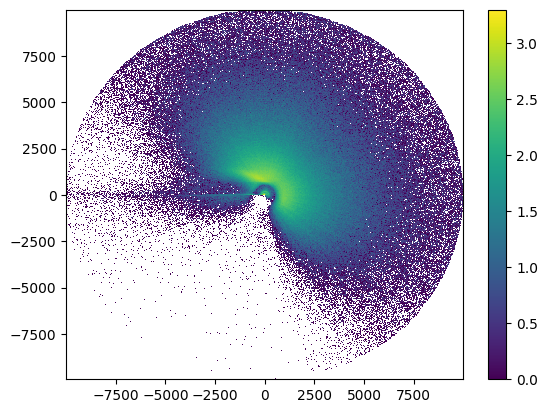

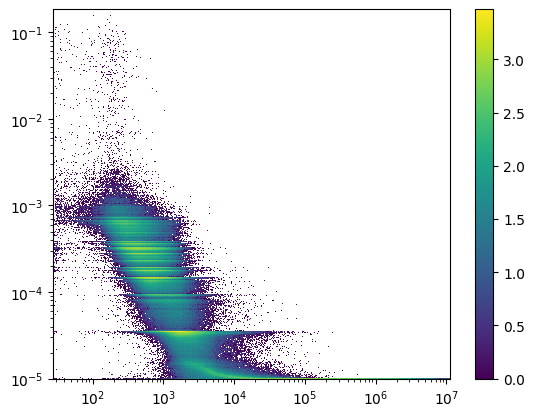

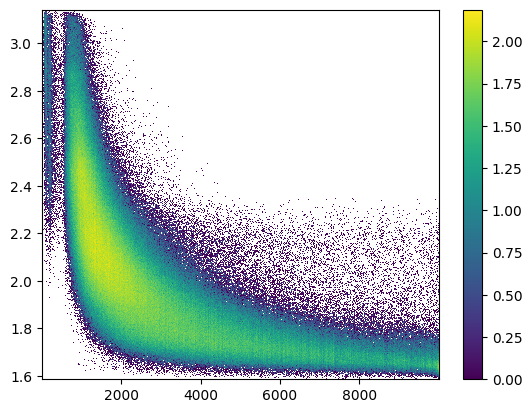

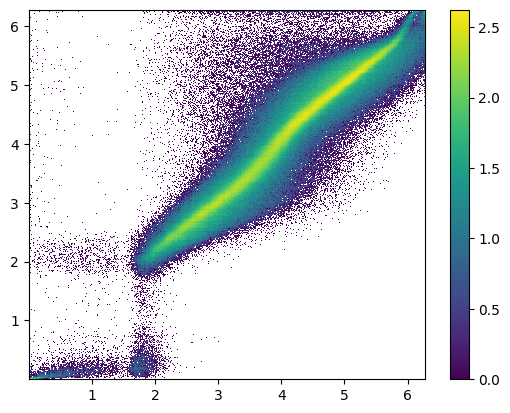

50/100	Loss_D: -42324.0404	Loss_G: 81618.7439


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


51/100	Loss_D: -43437.9562	Loss_G: 85811.0618


 batch: 0it [00:00, ?it/s]

52/100	Loss_D: -45186.3526	Loss_G: 89502.0299


 batch: 0it [00:00, ?it/s]

53/100	Loss_D: -47316.1964	Loss_G: 93726.8369


 batch: 0it [00:00, ?it/s]

54/100	Loss_D: -49015.6089	Loss_G: 94760.5687


 batch: 0it [00:00, ?it/s]

55/100	Loss_D: -50399.0620	Loss_G: 97896.1809


 batch: 0it [00:00, ?it/s]

56/100	Loss_D: -52159.4937	Loss_G: 99632.3024


 batch: 0it [00:00, ?it/s]

57/100	Loss_D: -53868.7788	Loss_G: 101618.4281


 batch: 0it [00:00, ?it/s]

58/100	Loss_D: -56334.8323	Loss_G: 103692.5049


 batch: 0it [00:00, ?it/s]

59/100	Loss_D: -58448.1905	Loss_G: 105975.6698


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


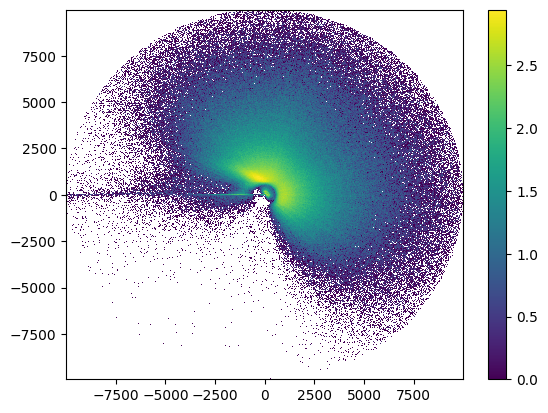

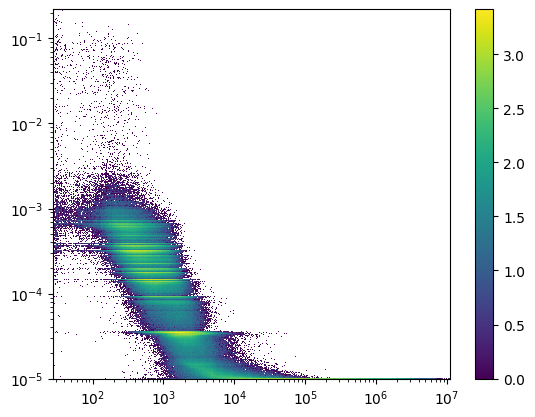

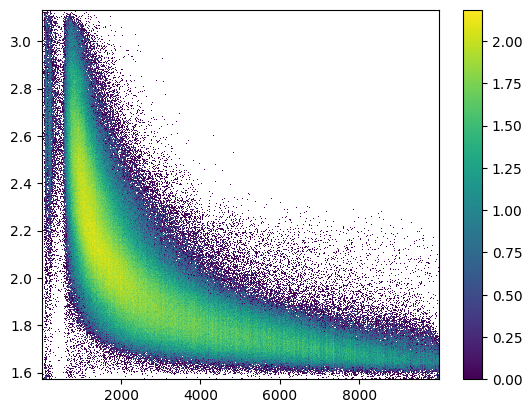

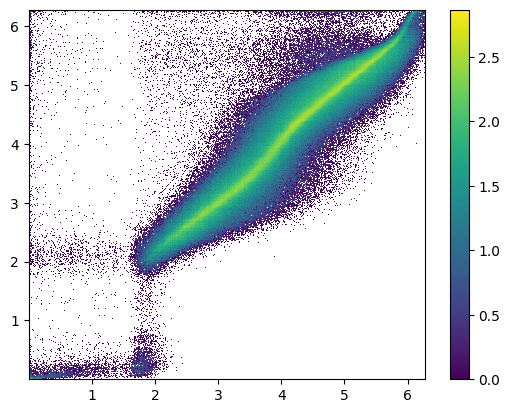

60/100	Loss_D: -60281.7595	Loss_G: 107519.7958


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


61/100	Loss_D: -62369.1206	Loss_G: 109910.7752


 batch: 0it [00:00, ?it/s]

62/100	Loss_D: -64287.1009	Loss_G: 113775.5215


 batch: 0it [00:00, ?it/s]

63/100	Loss_D: -65914.1497	Loss_G: 115101.4204


 batch: 0it [00:00, ?it/s]

64/100	Loss_D: -67123.1959	Loss_G: 119359.6514


 batch: 0it [00:00, ?it/s]

65/100	Loss_D: -69569.3360	Loss_G: 121240.7643


 batch: 0it [00:00, ?it/s]

66/100	Loss_D: -71117.0108	Loss_G: 124668.7229


 batch: 0it [00:00, ?it/s]

67/100	Loss_D: -73390.7526	Loss_G: 129277.0212


 batch: 0it [00:00, ?it/s]

68/100	Loss_D: -75510.5479	Loss_G: 133118.2300


 batch: 0it [00:00, ?it/s]

69/100	Loss_D: -77370.0825	Loss_G: 135016.3132


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


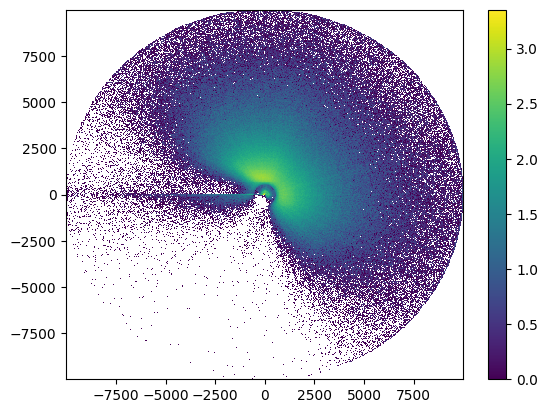

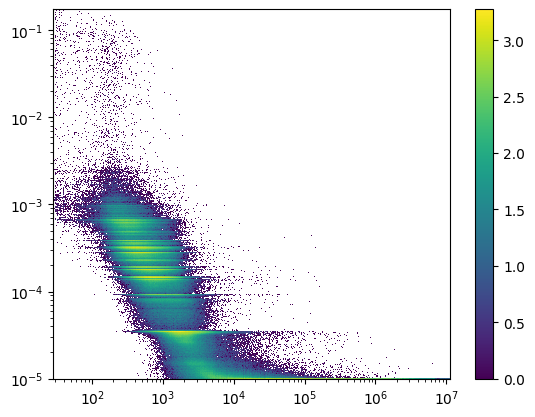

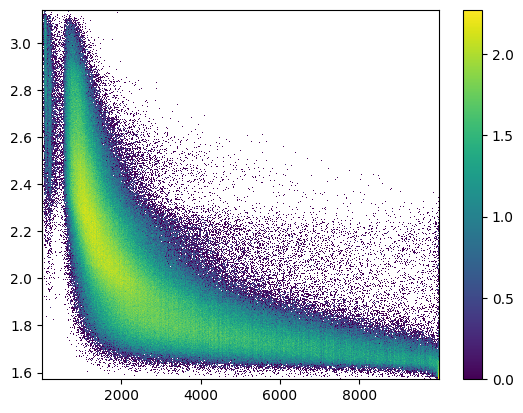

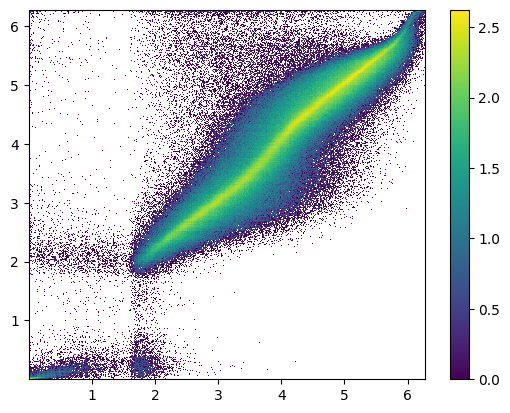

70/100	Loss_D: -78960.0392	Loss_G: 137972.6806


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


71/100	Loss_D: -80520.2645	Loss_G: 142431.5768


 batch: 0it [00:00, ?it/s]

72/100	Loss_D: -81973.7707	Loss_G: 147126.2350


 batch: 0it [00:00, ?it/s]

73/100	Loss_D: -83487.5820	Loss_G: 152095.3717


 batch: 0it [00:00, ?it/s]

74/100	Loss_D: -85677.8249	Loss_G: 156106.9346


 batch: 0it [00:00, ?it/s]

75/100	Loss_D: -88284.2759	Loss_G: 153046.3210


 batch: 0it [00:00, ?it/s]

76/100	Loss_D: -90384.8169	Loss_G: 156128.1047


 batch: 0it [00:00, ?it/s]

77/100	Loss_D: -93066.3865	Loss_G: 158789.4845


 batch: 0it [00:00, ?it/s]

78/100	Loss_D: -94917.9863	Loss_G: 159594.8135


 batch: 0it [00:00, ?it/s]

79/100	Loss_D: -97228.5027	Loss_G: 158723.2181


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


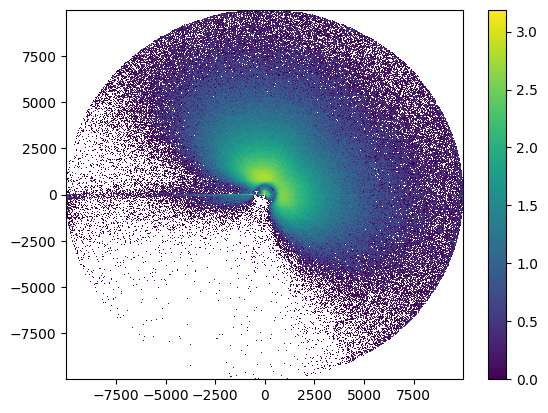

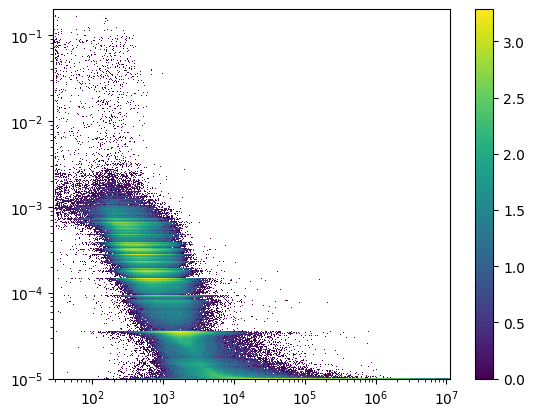

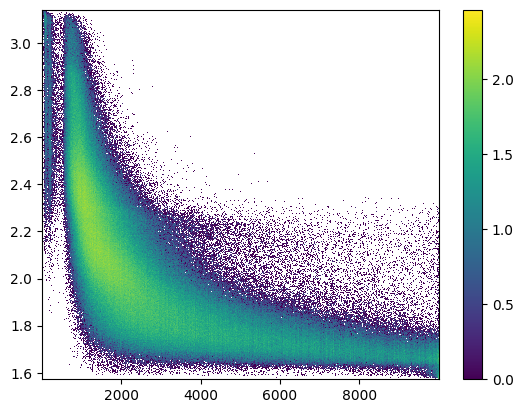

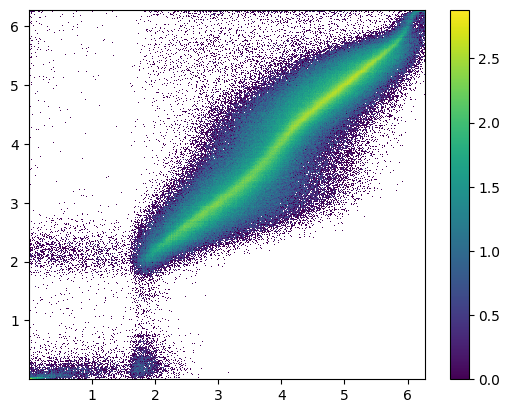

80/100	Loss_D: -99587.0734	Loss_G: 160893.9686


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


81/100	Loss_D: -100700.0845	Loss_G: 162572.1913


 batch: 0it [00:00, ?it/s]

82/100	Loss_D: -103423.6041	Loss_G: 165509.1262


 batch: 0it [00:00, ?it/s]

83/100	Loss_D: -105242.5603	Loss_G: 166507.5719


 batch: 0it [00:00, ?it/s]

84/100	Loss_D: -109011.8779	Loss_G: 164076.0720


 batch: 0it [00:00, ?it/s]

85/100	Loss_D: -112166.4792	Loss_G: 174784.5794


 batch: 0it [00:00, ?it/s]

86/100	Loss_D: -116386.6270	Loss_G: 178610.2093


 batch: 0it [00:00, ?it/s]

87/100	Loss_D: -118750.1544	Loss_G: 186290.2737


 batch: 0it [00:00, ?it/s]

88/100	Loss_D: -121356.1509	Loss_G: 188173.3664


 batch: 0it [00:00, ?it/s]

89/100	Loss_D: -125475.1115	Loss_G: 185955.1753


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


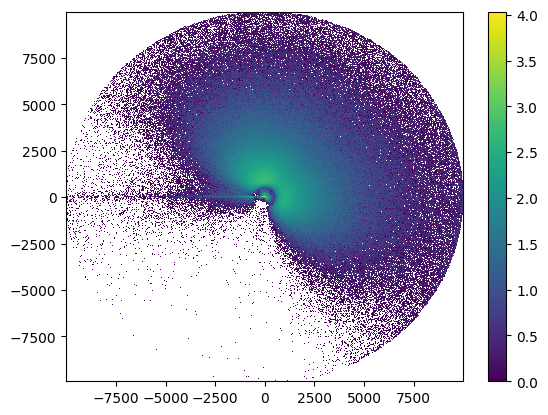

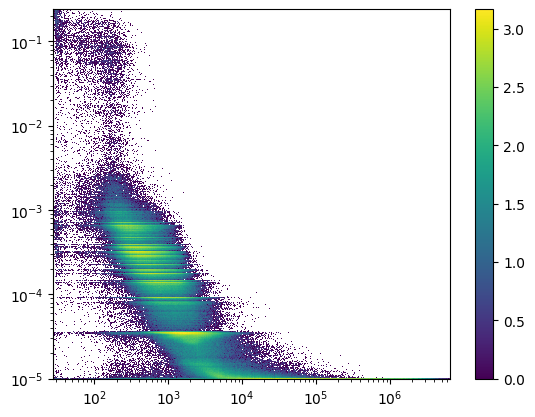

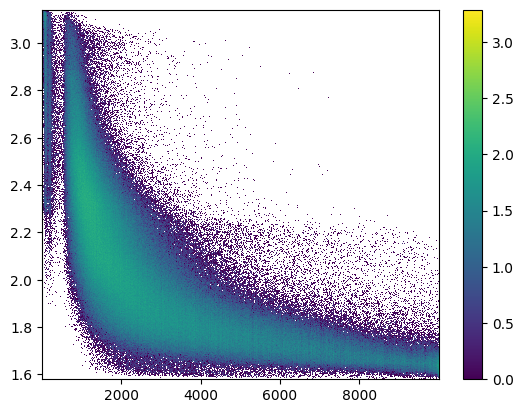

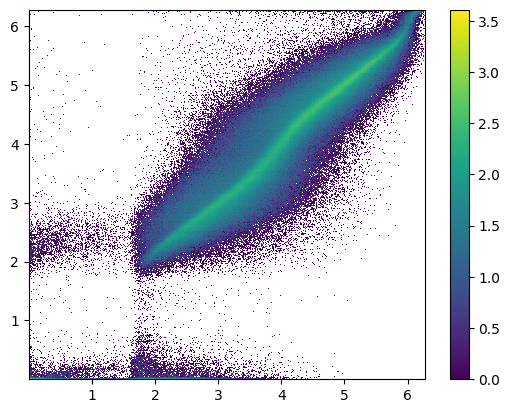

90/100	Loss_D: -124298.9567	Loss_G: 182960.2777


/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/871427700.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):


 batch: 0it [00:00, ?it/s]

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/torch/nn/modules/instancenorm.py:80: UserWarning: input's size at dim=0 does not match num_features. You can silence this warning by not passing in num_features, which is not used because affine=False
  warnings.warn(f"input's size at dim={feature_dim} does not match num_features. "


91/100	Loss_D: -125722.4516	Loss_G: 193187.6082


 batch: 0it [00:00, ?it/s]

92/100	Loss_D: -130171.5642	Loss_G: 208644.3644


 batch: 0it [00:00, ?it/s]

93/100	Loss_D: -133744.7016	Loss_G: 202889.9491


 batch: 0it [00:00, ?it/s]

94/100	Loss_D: -138141.6834	Loss_G: 202671.6158


 batch: 0it [00:00, ?it/s]

95/100	Loss_D: -141220.0701	Loss_G: 207213.0092


 batch: 0it [00:00, ?it/s]

96/100	Loss_D: -143669.6951	Loss_G: 206887.7770


 batch: 0it [00:00, ?it/s]

97/100	Loss_D: -146106.0156	Loss_G: 212368.1140


 batch: 0it [00:00, ?it/s]

98/100	Loss_D: -148083.8223	Loss_G: 214232.4366


 batch: 0it [00:00, ?it/s]

99/100	Loss_D: -150091.2998	Loss_G: 210662.7171


In [36]:
G_losses = []
D_losses = []
iters = 0
num_epochs = 100

#net_G.apply(weights_init)
#net_D.apply(weights_init)
generated_df = pd.DataFrame([])

print("Starting Training Loop...")

for epoch in tqdm.tqdm_notebook(range(num_epochs), desc=' epochs', position=0):
    net_G.to(mps_device)
    net_G.train()

    avg_error_G, avg_error_D = 0, 0
    avg_Dx, avg_DGz1, avg_DGz2 = 0., 0., 0.

    for i, data in tqdm.tqdm_notebook(enumerate(dataloader, 0), desc=' batch', position=1, leave=False):

        # Update the discriminator network

        ## Train with all-real batch
        net_D.zero_grad()
        b_size = len(data)
        real_data = data.to(mps_device)
        
        output = net_D(real_data)

        err_D_real = -torch.mean(output)
        D_x = output.mean().item()
        
        ## Train with all-fake batch
        noise = torch.randn(b_size, N_z, device=mps_device)
        fake_p = net_G(noise)

        output = net_D(fake_p.detach())
        err_D_fake = torch.mean(output)
        fake_p.to(mps_device)
        err_D = err_D_real + err_D_fake
        err_D.backward()

        # update the discriminator network
        optimizer_D.step()
        
        # Update the Generator network
        net_G.zero_grad()
        output = net_D(fake_p)
        err_G = -torch.mean(output)
        err_G.backward()
        
        # update the generator network
        optimizer_G.step()
        
        # computing the average losses and discriminator
        avg_error_G += err_G.item()
        avg_error_D += err_D.item()

        iters += 1
        
    if len(G_losses)>0:
        if avg_error_G<G_losses[-1]:
            torch.save(net_G.state_dict(), 'saved_Gen.pt')
    if np.mod(epoch,10)==0:
        noise = torch.randn(1154756, N_z, device='cpu')
        net_G.eval()
        net_G.to('cpu')
        fake_p = net_G(noise).detach().numpy()
        generated_df = pd.DataFrame([])
        param_list = [' rx',' phi_x',' rp',' phi_p',' pzz',' eneg',' time']
        for i in range(len(param_list)):
            generated_df[param_list[i]]= fake_p[:,i]
        plots(transform(generated_df, dataset, fake_p))
    G_losses.append(avg_error_G)
    D_losses.append(avg_error_D)
    print(f'{epoch}/{num_epochs}\tLoss_D: {avg_error_D:.4f}\tLoss_G: {avg_error_G:.4f}')

/Users/alonlevi/PycharmProjects/ML_Project/venv/lib/python3.9/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but QuantileTransformer was fitted with feature names
  warnings.warn(
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/3125626096.py:13: RuntimeWarning: divide by zero encountered in divide
  plt.plot(fake_hist[1][:-1],fake_hist[0]/data_hist[0])
/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/3125626096.py:13: RuntimeWarning: invalid value encountered in divide
  plt.plot(fake_hist[1][:-1],fake_hist[0]/data_hist[0])


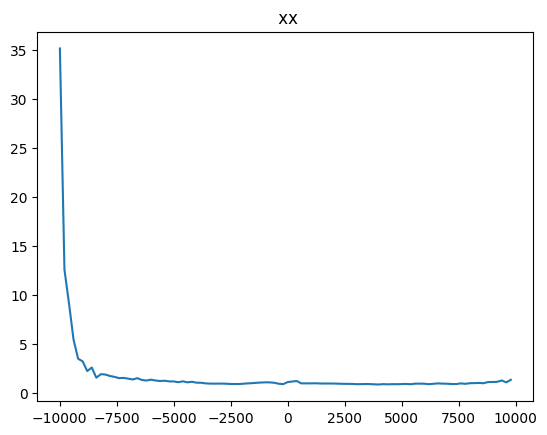

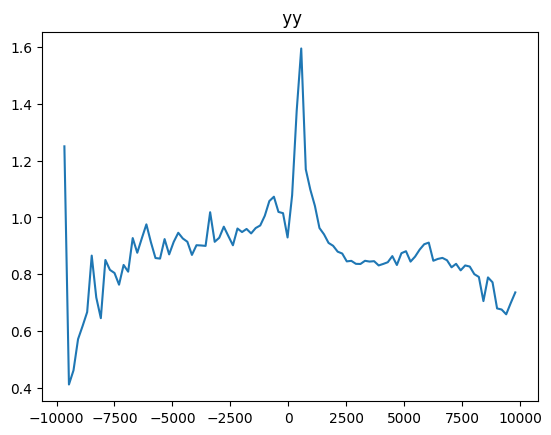

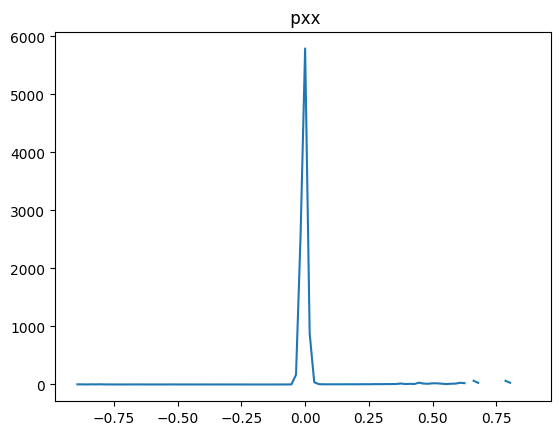

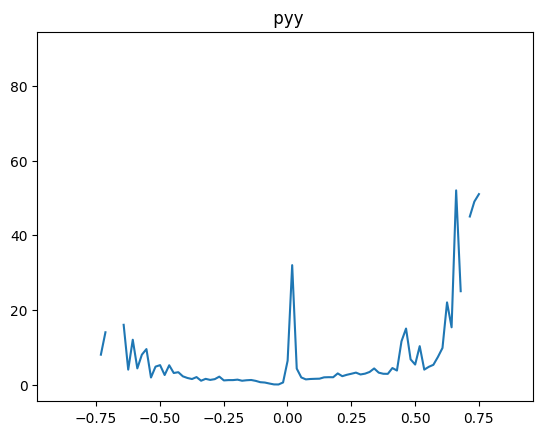

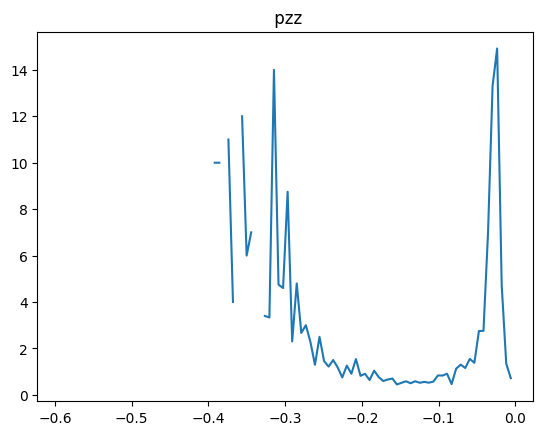

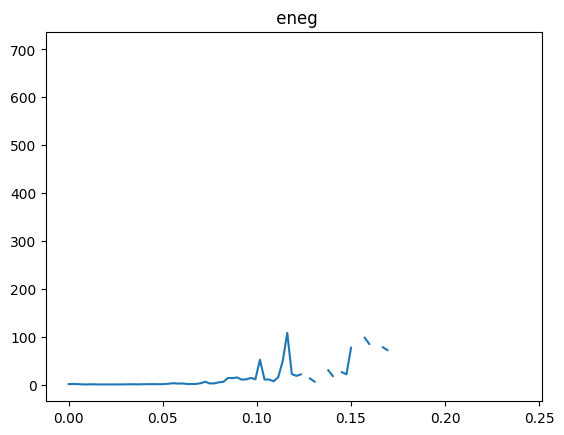

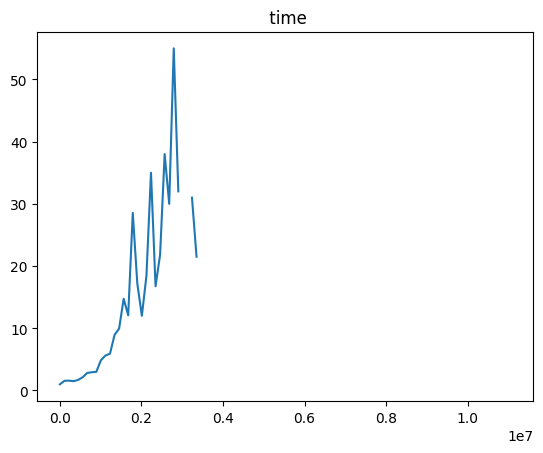

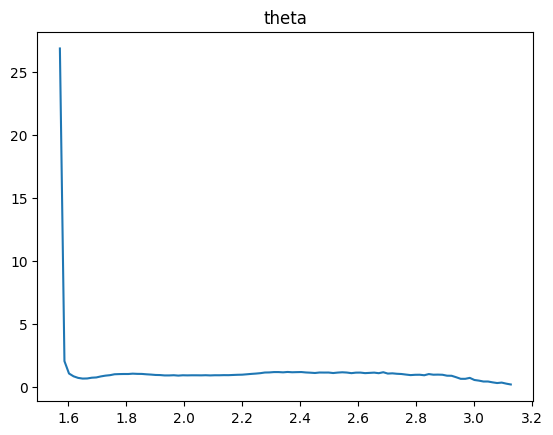

<Figure size 640x480 with 0 Axes>

In [42]:
param_list = [' xx',' yy',' pxx',' pyy',' pzz',' eneg',' time','theta']
noise = torch.randn(1154756, N_z, device='cpu')
net_G.eval()
net_G.to('cpu')
fake_p = net_G(noise).detach().numpy()
generated_df = pd.DataFrame([])
for i in range(len(param_list)-1):
    generated_df[param_list[i]]= fake_p[:,i]
DF = transform(generated_df, dataset, fake_p)
for j in range(len(param_list)):
    fake_hist = np.histogram(DF[param_list[j]],bins=100)
    data_hist = np.histogram(df_N[param_list[j]],bins=100)
    plt.plot(fake_hist[1][:-1],fake_hist[0]/data_hist[0])
    plt.title(param_list[j])
    plt.figure()

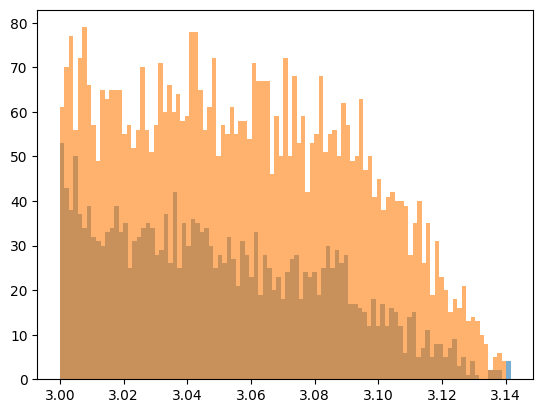

In [41]:
mask=3
crit_theta_fake = DF[DF['theta']>=mask]
crit_theta_real = df_N[df_N['theta']>=mask]
plt.hist(crit_theta_fake['theta'],bins=100,alpha=0.6)
plt.hist(crit_theta_real['theta'],bins=100,alpha=0.6)
plt.show()

/var/folders/x1/m91t__39123gp_24cgkx3x3m0000gp/T/ipykernel_45142/2550337054.py:4: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(X,Y,np.log10(H.T))


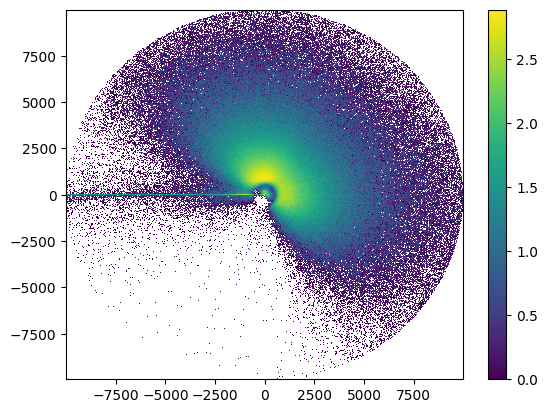

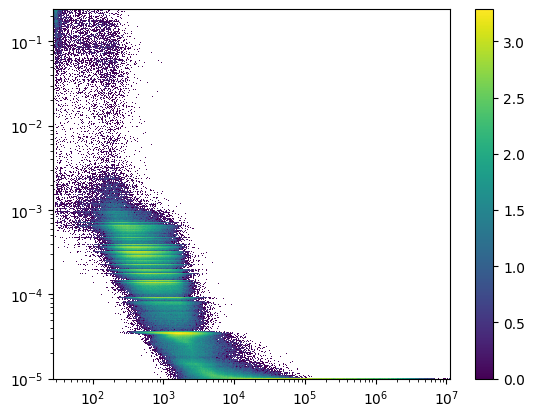

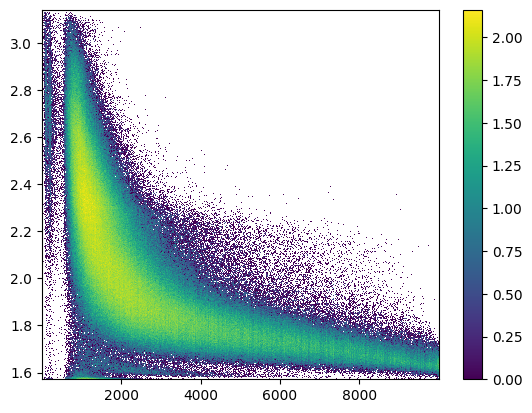

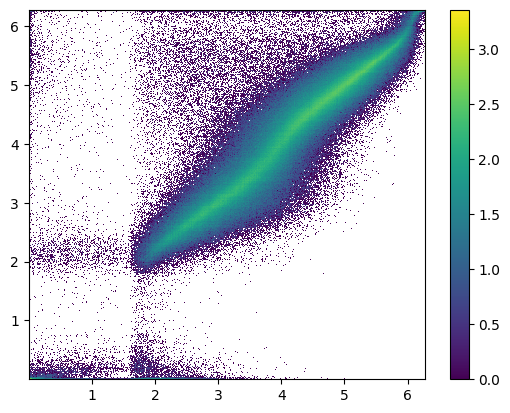

In [38]:
plots(DF)